# Exercises for Bayesian Statistics

The following script is the solution the exercises for the probability theory section (ie. the exercises 12-16) of the course 'Statistics for Data Science' (WS 19/20) by Prof. Ostwald. The exercise sheets can be found at the website https://www.ewi-psy.fu-berlin.de/einrichtungen/arbeitsbereiche/computational_cogni_neurosc/teaching/Statistics_for_Data_Science_19_20.html.

## Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# For reproducibility, fix seed.
np.random.seed(42)

## 12. Foundations and Conjugate Inference

### 1. Batch vs. Recursive Bayesian Estimation for Beta-Binomial Model

For the beta-binomial model, we'll have three steps:

1) Choose Prior: Choose beta distribution $P(\theta)$.

2) Likelihood: Generate Data with binomial distribution, $P(x|\theta)$.

3) Make Posterior. $P(\theta|x) \propto P(x|\theta) P(\theta)$.

Then, the comparison batch vs. recursive is made.

In [3]:
from scipy.stats import binom, beta, bernoulli

#### 1. Prior

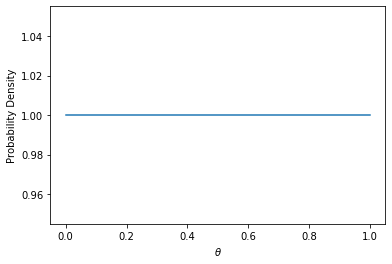

In [4]:
theta_range = np.linspace(0, 1, 1000)
theta_range_plus_eps = theta_range + 0.001
a = 1
b = 1

# Visualization.
prior = beta.pdf(x = theta_range, a = a, b = b)
plt.plot(theta_range, prior)
plt.xlabel(r"$\theta$")
plt.ylabel('Probability Density')

# Taking difference of cdfs as we need to have probability (here PMF)
# not the density given by beta.pdf for further calculations.
prior = beta.cdf(x = theta_range_plus_eps, a = a, b = b) - beta.cdf(x = theta_range, a = a, b = b) 

#### 2. Likelihood

In [5]:
# Generate data
n = 10
theta_unknown = 0.3
n_pos = np.random.binomial(n, theta_unknown)
n_pos

2

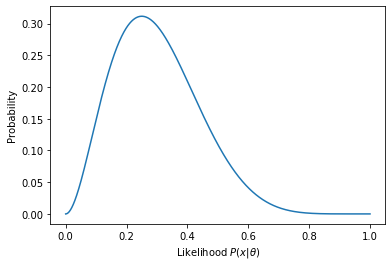

In [6]:
likelihood = binom.pmf(k = n_pos, n = n - n_pos, p = theta_range) 
plt.plot(theta_range, likelihood)
plt.xlabel(r"Likelihood $P(x|\theta)$")
plt.ylabel("Probability");

#### 3. Posterior

In [7]:
posterior = likelihood * prior 
normalized_posterior = posterior / np.sum(posterior)

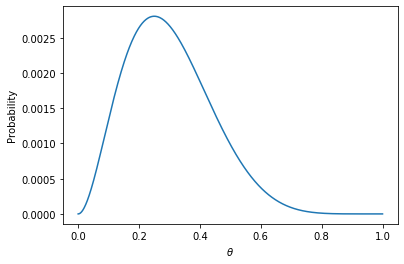

In [8]:
plt.plot(theta_range, normalized_posterior)
plt.xlabel(r"$\theta$")
plt.ylabel("Probability");

However, we can also use the fact that we know the posterior will be also a beta distribution (as beta is the conjugate prior in this case). This yields the following for comparing batch and recursive bayesian estimation:

#### Batch vs. Recursive Estimation

In [9]:
n = 10
sample = bernoulli.rvs(theta_unknown, size = n)
n_pos = sample.sum()

prior = beta.pdf(x = theta_range, a = a, b = b)
posterior_batch = beta.pdf(x = theta_range, a = a + n_pos, b = b + n - n_pos)

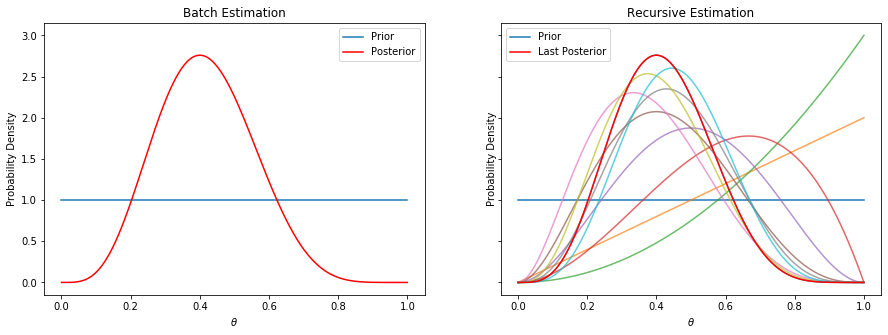

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=True)

for ax in axs:
    ax.plot(theta_range, prior, label = "Prior")
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel('Probability Density')
    

# Batch
axs[0].set_title("Batch Estimation")
axs[0].plot(theta_range, posterior_batch, color = 'red', label = "Posterior")

# Recursive
axs[1].set_title("Recursive Estimation")
for num, i in enumerate(sample):
    a = a + i
    b = b + 1 - i
    posterior_rec = beta.pdf(x = theta_range, a = a, b = b)
    axs[1].plot(theta_range, posterior_rec, alpha = 0.7)
    if num == n-1:
        axs[1].plot(theta_range, posterior_rec, color = 'red', label = 'Last Posterior')

axs[0].legend()
axs[1].legend()

plt.legend();

#### Observation

You can see with the recursive estimation that the prior we started with is taken less and less into account. The new prior is always the previous posterior!
As expected, the recursive and batch Bayesian estimation yield the same result when all samples are taken into account.

### 2. Bias and Consistency Properties of the Posterior Expected Value (Beta-Binomial Model)

1) Show the bias of the posterior PMF by calculating:
$\mathbb{E}_{\theta}(\hat{\theta}_n)$.

2) Show consistency by showing
$lim_{n \to \infty} \mathbb{P}_{\theta}(|\hat{\theta}_n-\theta|<\epsilon)=1$


#### Bias

In [11]:
def get_theta_estimate(theta_unknown=0.8, n=1000):
    "Get posterior using uniform prior. This represents one run, i.e. one theta_n."
    a = 1
    b = 1
    prior = beta.pdf(x = theta_range, a = a, b = b)
    n_pos = np.random.binomial(n, theta_unknown)
    posterior_batch = beta.pdf(x = theta_range, a = a + n_pos, b = b + n - n_pos)
    return np.mean(posterior_batch * theta_range)

In [12]:
m = 1000
theta_unknown = 0.8
res = []
for _ in range(m):
    res.append(get_theta_estimate(theta_unknown))

Deviations of expected value from theta to true theta: -0.001904682634353505


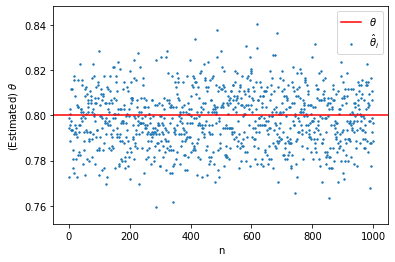

In [13]:
plt.scatter(np.arange(0, m), res, s = 2, label = r'$\hat{\theta}_i$')
plt.axhline(theta_unknown, color = 'red', label = r'$\theta$')
plt.legend()
plt.xlabel('n')
plt.ylabel(r'(Estimated) $\theta$')
print("Deviations of expected value from theta to true theta:", np.mean(res)-theta_unknown)

#### Observation
The posterior expected value seems unbiased.

#### Consistency

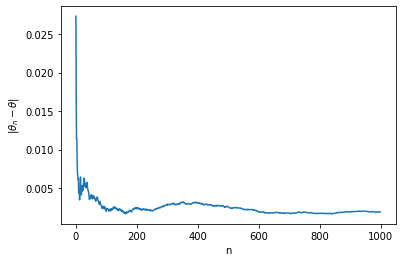

In [14]:
averages = np.cumsum(res)/np.arange(1, m+1)
total_deviation = np.abs(averages - theta_unknown)

plt.plot(total_deviation)
plt.xlabel('n')
plt.ylabel(r'$|\theta_n - \theta|$');

#### Observation

The posterior of the expected value seems to be a consistent estimator. (One could, of course, now come up with an epsilon and see how the average of the expected value will not deviate more than epsilon to the true theta, there do not seem to be great fluctuations for $lim_{n \to \infty}$.

### 3. Bias and Consistency Properties of the Posterior Expected Value (Gaussian-Gaussian Model)

In [15]:
mu_unknown = 5
var_unknown = 2

mu_start = 2
var_start = 1

sample_size = 1000
n = 5000

In [16]:
def get_mu_estimate(mu_start, var_start, mu_unknown, var_unknown, sample_size = 1000):
    sample = np.random.normal(mu_unknown, var_unknown, n)
    mean_ = np.mean(sample)
    var_ = np.var(sample, ddof=1)
    return (1/(sample_size/var_ + 1/var_start))* (mu_start/var_start + sample_size * mean_/var_)

In [17]:
mus_est = []
for _ in range(n):
    mus_est.append(get_mu_estimate(mu_start, var_start, mu_unknown, var_unknown, sample_size))

Deviations of expected value from theta to true theta: -0.011980325827741112


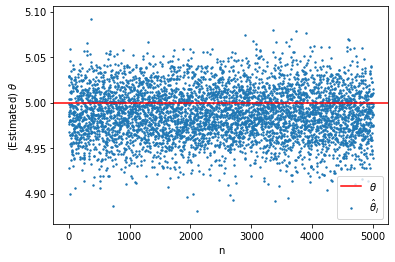

In [18]:
plt.scatter(np.arange(0, n), mus_est, s = 2, label = r'$\hat{\theta}_i$')
plt.axhline(mu_unknown, color = 'red', label = r'$\theta$')
plt.legend()
plt.xlabel('n')
plt.ylabel(r'(Estimated) $\theta$')
print("Deviations of expected value from theta to true theta:", np.mean(mus_est) - mu_unknown)

The deviation of the expected value is larger than for the beta-binomial model; even if more estimations are taken into account. From the figure, it seems that the estimate is a little off, but this might be also due to numeric errors - the expected value of the sequence of the estimator is close to 0 so it might also be unbiased.

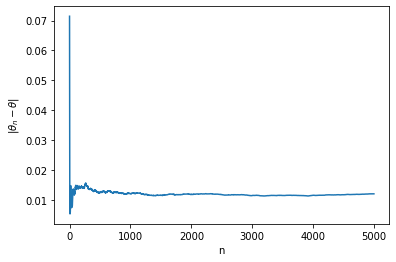

In [19]:
averages = np.cumsum(mus_est)/np.arange(1, n+1)
total_deviation = np.abs(averages - mu_unknown)

plt.plot(total_deviation)
plt.xlabel('n')
plt.ylabel(r'$|\theta_n - \theta|$');

The estimator seems consistent.

## 13. Bayesian Filtering

In [20]:
# from bayesian_filtering import kalman_filter, rauch_tung_striebel_smoother

To me, it is not clear how the predic

- x observations
- 

1 [1.68922599]
2 [-0.21800571]
3 [0.04747941]
4 [0.72730803]
5 [0.5900251]
6 [1.71187008]
7 [0.65942276]
8 [0.59648466]
9 [-0.69511792]
10 [0.1819482]
11 [-2.12756379]
12 [0.20267619]
13 [0.97019489]
14 [0.93203118]
15 [0.2683871]
16 [-0.58018669]
17 [-0.41089489]
18 [1.23315583]
19 [1.36704301]
20 [2.4263467]
21 [3.27712705]
22 [2.26846103]
23 [1.60218968]
24 [1.52548322]
25 [1.86084079]
26 [2.05319268]
27 [1.72284652]
28 [2.31278165]
29 [5.06442438]
30 [4.31233222]
31 [4.01037574]
32 [5.04112033]
33 [5.04425512]
34 [5.645808]
35 [5.93163398]
36 [6.5423947]
37 [6.59068959]
38 [7.64473267]
39 [5.21288598]
40 [3.4584487]
41 [6.71494478]
42 [3.87496537]
43 [2.85464832]
44 [4.06834447]
45 [3.09174213]
46 [5.31891923]
47 [4.75778874]
48 [6.30582881]
49 [5.4093949]
50 [5.21434366]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dmueller/Documents/BCCN_semesterwork/3/Figures/bayesian_filtering_1.pdf'

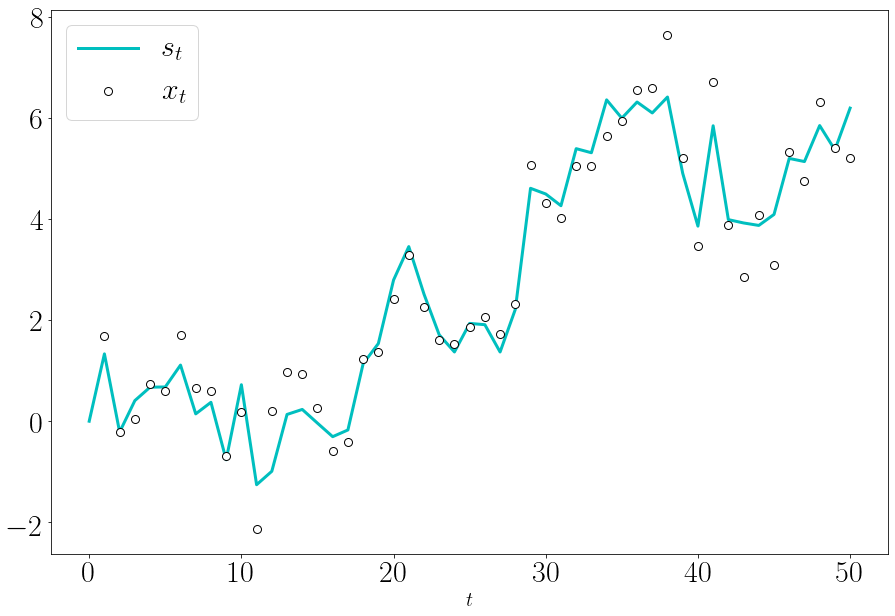

In [21]:
# Provided code from lecturer (so cannot uplaod this).

import bayesian_filtering as bf

In [ ]:
print(bf.kf.x_t)

In [ ]:
print(bf.m_t.flatten())

In [ ]:
plt.plot(bf.m_t.flatten())

### 1. Expectation of Filtered Distribution

### 2. Variance of Filtered Distribution